In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bvh_converter import bvh_mod
from scipy.signal import savgol_filter

from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

In [ ]:
file_name = "BKO_E1_D1_07_Suku"
pickle_path = f'data/motion_data_pkl/{file_name}_T.pkl'
    
# if os.path.isfile(pickle_path):
with open(pickle_path, 'rb') as file:
    motiondata_section = pickle.load(file)
print(f"Loaded {file_name} pickle")
    
Lfoot_xyzpos_data = motiondata_section["position"]["SEGMENT_LEFT_FOOT"]
Lfoot_zpos_data = savgol_filter(Lfoot_xyzpos_data[:,2], 60, 0)

Rfoot_xyzpos_data = motiondata_section["position"]["SEGMENT_RIGHT_FOOT"]
Rfoot_zpos_data = savgol_filter(Rfoot_xyzpos_data[:,2], 60, 0)

# V4: Detected Foot onset trajectories

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d

def plot_foot_trajectories(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    W_start: float = 170.0,
    W_end: float = 185.0,
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200
):
    """
    Plot left- and right-foot Y-position trajectories ±window around each downbeat,
    marking foot-onset times for cycles that have an onset in the window.

    Parameters
    ----------
    file_name
        Base name (e.g. "BKO_E1_D2_03_Suku")
    base_path_cycles
        Directory containing your virtual_cycles CSVs
    base_path_logs
        Directory containing your logs_v1_may/<file>_T/onset_info
    frame_rate
        Frame rate of the motion capture data
    W_start, W_end
        Time window (in seconds) around which to plot trajectories
    n_beats_per_cycle
        Beats per cycle (e.g. 4)
    n_subdiv_per_beat
        Subdivisions per beat (e.g. 12)
    nn
        Half-width in subdivisions: window_size_subdiv = 2*nn
    figsize
        Matplotlib figure size tuple
    dpi
        Matplotlib figure DPI

    Returns
    -------
    fig, ax
        The matplotlib Figure and Axes objects
    """
    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # trim to window
    win_mask = (times >= W_start) & (times <= W_end)
    t_win = times[win_mask]
    L_win = Lz[win_mask]
    R_win = Rz[win_mask]

    # cycles (downbeats)
    cyc_df = pd.read_csv(cycles_csv)
    cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= W_start) & (cyc_df["Virtual Onset"] <= W_end)]
    onsets = cyc_df["Virtual Onset"].values[:-1]
    durations = np.diff(cyc_df["Virtual Onset"].values)
    avg_cycle = durations.mean()

    # foot onsets
    left_df  = pd.read_csv(left_onsets_csv)
    right_df = pd.read_csv(right_onsets_csv)
    left_times  = left_df[ (left_df["time_sec"]>=W_start)&(left_df["time_sec"]<=W_end) ]["time_sec"].values
    right_times = right_df[(right_df["time_sec"]>=W_start)&(right_df["time_sec"]<=W_end)]["time_sec"].values

    # window half-width in seconds
    beat_len   = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win   = subdiv_len * nn

    # collect cycles that have foot onsets
    cyc_L, L_near = [], {}
    for c in onsets:
        hits = left_times[(left_times>=c-half_win)&(left_times<=c+half_win)]
        if len(hits):
            cyc_L.append(c); L_near[c] = hits

    cyc_R, R_near = [], {}
    for c in onsets:
        hits = right_times[(right_times>=c-half_win)&(right_times<=c+half_win)]
        if len(hits):
            cyc_R.append(c); R_near[c] = hits

    # plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cmap = plt.get_cmap('cool')
    t_range = W_end - W_start

    # left foot
    for i, c in enumerate(cyc_L):
        col = cmap((c-W_start)/t_range)
        m = (t_win>=c-half_win)&(t_win<=c+half_win)
        tr = t_win[m] - c
        ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                label="Left Foot" if i==0 else "")
        for lt in L_near[c]:
            rel = lt - c
            ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
            ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', alpha=0.8)

    # right foot
    for i, c in enumerate(cyc_R):
        col = cmap((c-W_start)/t_range)
        m = (t_win>=c-half_win)&(t_win<=c+half_win)
        tr = t_win[m] - c
        ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                label="Right Foot" if i==0 else "")
        for rt in R_near[c]:
            rel = rt - c
            ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
            ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='k', alpha=0.8)

    # decorations
    ax.axvline(0, color='k', linewidth=1.5, label="Downbeat (t=0)")
    # subdivision lines
    for j in range(-nn, nn+1):
        if j!=0:
            ax.axvline(j*subdiv_len, color='gray', linestyle=':', alpha=0.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(W_start, W_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time in recording (s)')

    custom = [
        Line2D([0],[0],color='blue',linestyle='-', lw=2),
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],color='blue',linestyle='--', lw=2),
        Line2D([0],[0],marker='x', color='w', markeredgecolor='blue', ms=8),
        Line2D([0],[0],color='k', lw=2)
    ]
    labels = ["Left Trajectory","Left Onset","Right Trajectory",
              "Right Onset","Downbeat (t=0)"]
    ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    ax.set_xlabel("Time relative to downbeat (s)")
    ax.set_ylabel("Foot Y Position")
    ax.set_title(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around downbeats\n"
        f"{file_name} | window {W_start}-{W_end}s | {mode}",
        fontsize=10
    )
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig, ax


## Batch process trajectory plots

In [ ]:
# mode_csv = "data/subset_dance_annotation/BKO_E1_D5_04_Suku_Dancers.csv"

mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract a (start, end) tuple or None
    def get_segment(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return (df["Start (in sec)"].iat[0],
                df["End (in sec)"].iat[0])

    # build a dict of segments
    segments = {
        "group":      get_segment(mode_group,      "gr"),
        "individual": get_segment(mode_individual, "in"),
        "audience":   get_segment(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, tup in tsegment.items():
        fig, ax = plot_foot_trajectories(
            file_name= file_name,
            mode = mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            W_start=tup[0], W_end=tup[1],
            n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8
        )
        fig.savefig(os.path.join(save_dir, f"{file_name}_{tup[0]}_{tup[1]}.png"))
        plt.close(fig)
        # plt.show()


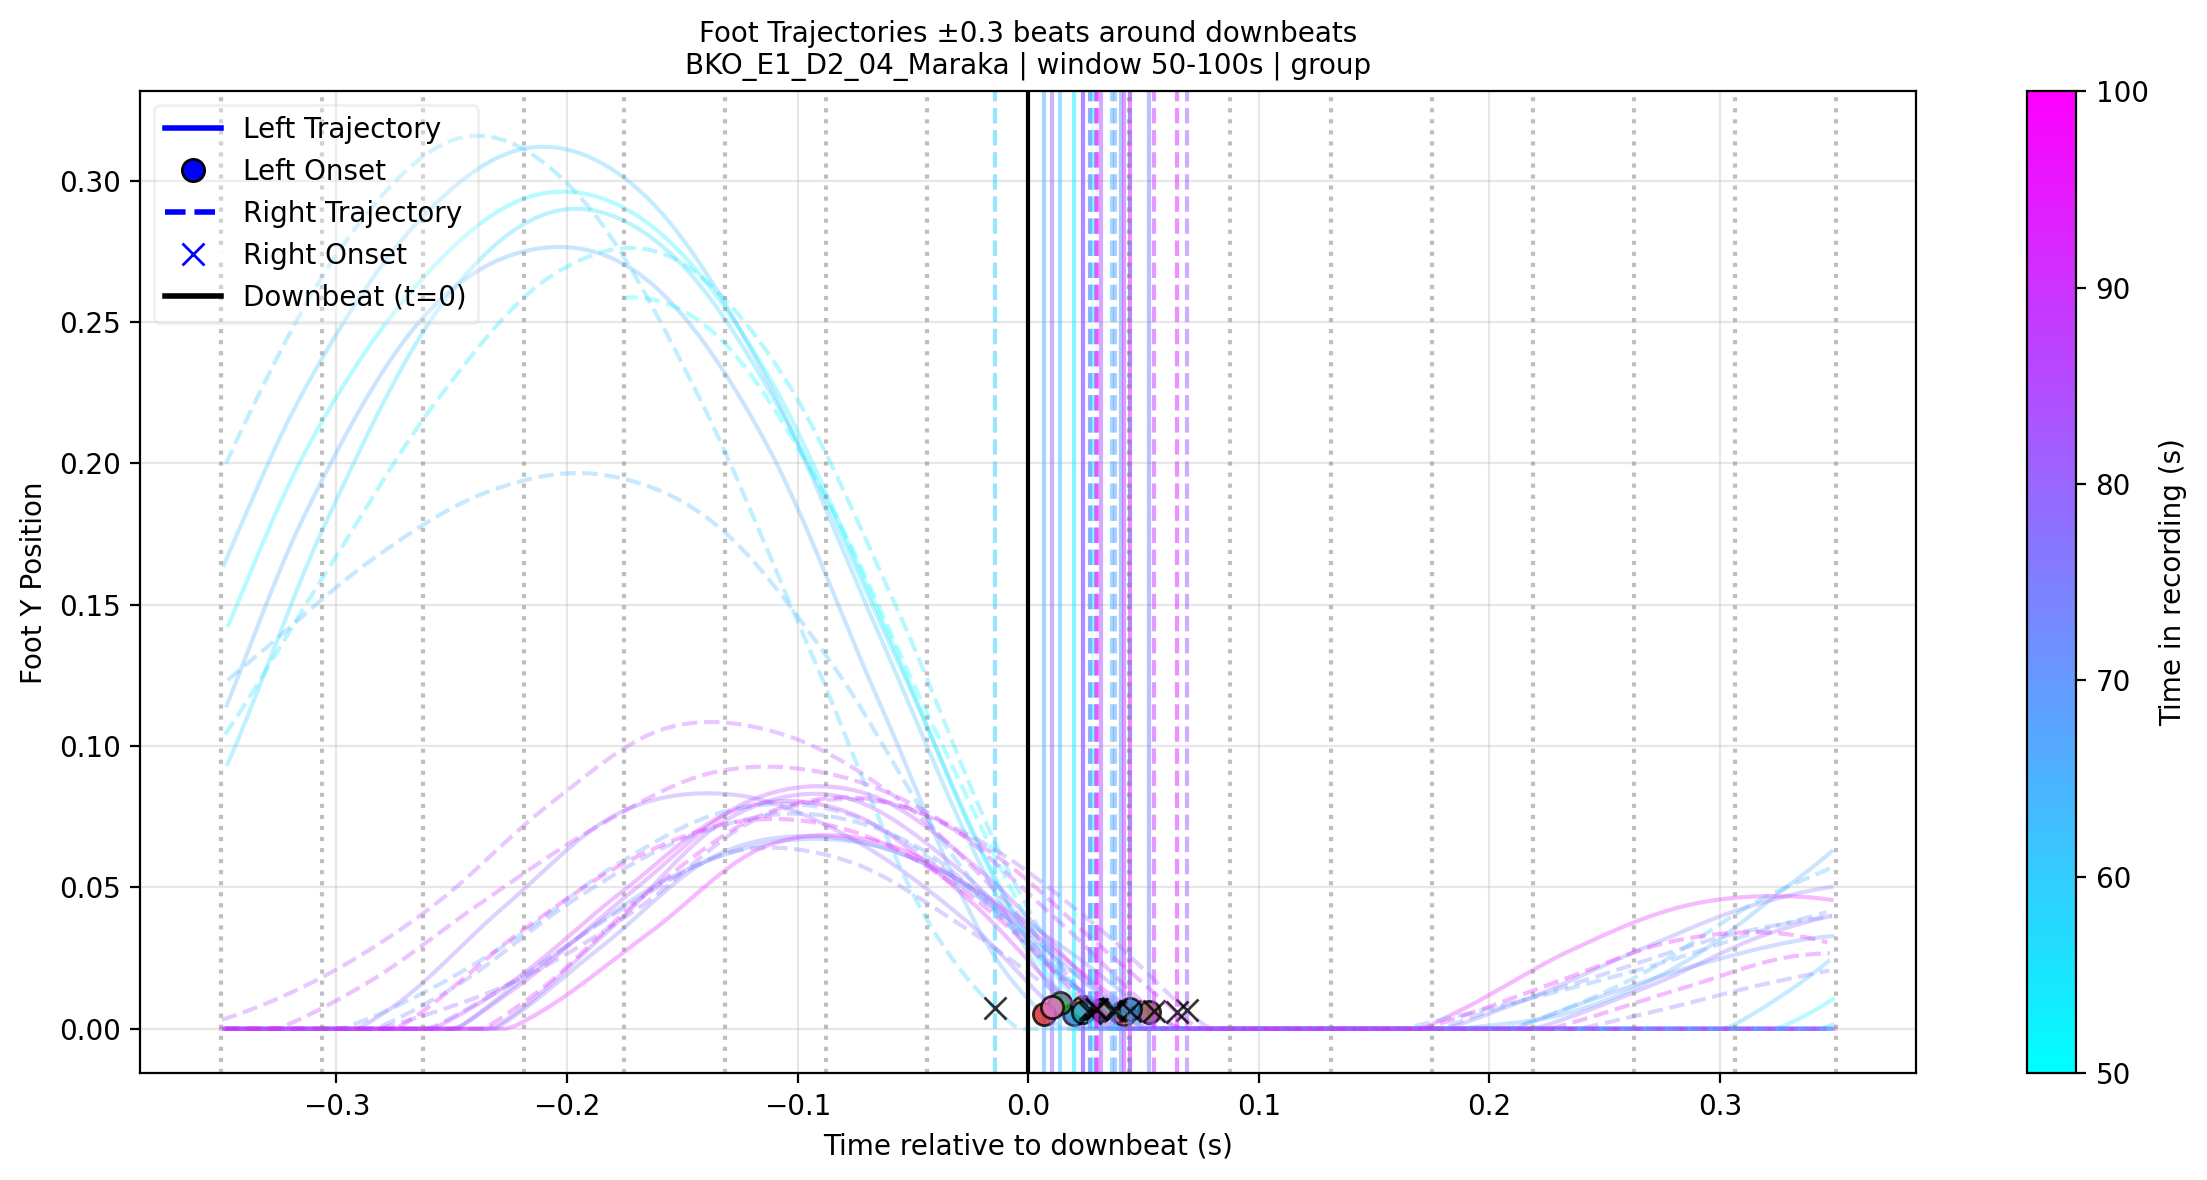

In [6]:

fig, ax = plot_foot_trajectories(
    file_name="BKO_E1_D2_04_Maraka",
    mode="group",
    base_path_cycles="data/virtual_cycles",
    base_path_logs="data/logs_v1_may",
    W_start= 50, W_end= 100,
    n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8
)
plt.show()

## V5: Detected + Non Detected Foot onset trajectories

In [7]:
def plot_foot_trajectories(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    W_start: float = 170.0,
    W_end: float = 185.0,
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,  # New parameter to control x-axis units
    show_gray_plots: bool = True        # show non detected foot onsets trajectories
):
    """
    Plot left- and right-foot Y-position trajectories ±window around each downbeat,
    marking foot-onset times for cycles that have an onset in the window.
    Also plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    use_cycles : bool
        If True, x-axis shows cycles (0 = downbeat, 1 = next downbeat)
        If False, x-axis shows seconds relative to downbeat
    """
    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # trim to window
    win_mask = (times >= W_start) & (times <= W_end)
    t_win = times[win_mask]
    L_win = Lz[win_mask]
    R_win = Rz[win_mask]

    # cycles (downbeats)
    cyc_df = pd.read_csv(cycles_csv)
    cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= W_start) & (cyc_df["Virtual Onset"] <= W_end)]
    onsets = cyc_df["Virtual Onset"].values[:-1]
    durations = np.diff(cyc_df["Virtual Onset"].values)
    avg_cycle = durations.mean()

    # foot onsets
    left_df  = pd.read_csv(left_onsets_csv)
    right_df = pd.read_csv(right_onsets_csv)
    left_times  = left_df[ (left_df["time_sec"]>=W_start)&(left_df["time_sec"]<=W_end) ]["time_sec"].values
    right_times = right_df[(right_df["time_sec"]>=W_start)&(right_df["time_sec"]<=W_end)]["time_sec"].values

    # window half-width in seconds
    beat_len   = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win   = subdiv_len * nn

    # collect cycles that have foot onsets
    cyc_L, L_near = [], {}
    for c in onsets:
        hits = left_times[(left_times>=c-half_win)&(left_times<=c+half_win)]
        if len(hits):
            cyc_L.append(c); L_near[c] = hits

    cyc_R, R_near = [], {}
    for c in onsets:
        hits = right_times[(right_times>=c-half_win)&(right_times<=c+half_win)]
        if len(hits):
            cyc_R.append(c); R_near[c] = hits

    # plotting
    fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
    cmap = plt.get_cmap('cool')
    t_range = W_end - W_start

    # Plot all cycles first (gray/transparent)
    if show_gray_plots:
        for c in onsets:
            m = (t_win>=c-half_win)&(t_win<=c+half_win)
            tr = t_win[m] - c
            if use_cycles:
                tr = tr / avg_cycle  # Convert to cycles
            # Plot left foot
            ax.plot(tr, L_win[m], '-', color='gray', alpha=0.5)
            # Plot right foot
            ax.plot(tr, R_win[m], '--', color='gray', alpha=0.5)

    # left foot (with onsets)
    for i, c in enumerate(cyc_L):
        col = cmap((c-W_start)/t_range)
        m = (t_win>=c-half_win)&(t_win<=c+half_win)
        tr = t_win[m] - c
        if use_cycles:
            tr = tr / avg_cycle  # Convert to cycles
        ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                label="Left Foot" if i==0 else "")
        for lt in L_near[c]:
            rel = lt - c
            if use_cycles:
                rel = rel / avg_cycle  # Convert to cycles
            ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
            ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', alpha=0.8)

    # right foot (with onsets)
    for i, c in enumerate(cyc_R):
        col = cmap((c-W_start)/t_range)
        m = (t_win>=c-half_win)&(t_win<=c+half_win)
        tr = t_win[m] - c
        if use_cycles:
            tr = tr / avg_cycle  # Convert to cycles
        ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                label="Right Foot" if i==0 else "")
        for rt in R_near[c]:
            rel = rt - c
            if use_cycles:
                rel = rel / avg_cycle  # Convert to cycles
            ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
            ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='k', alpha=0.8)

    # decorations
    ax.axvline(0, color='k', linewidth=1.5, label="Downbeat (t=0)")
    # subdivision lines
    for j in range(-nn, nn+1):
        if j!=0:
            pos = j*subdiv_len
            if use_cycles:
                pos = pos / avg_cycle  # Convert to cycles
            ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(W_start, W_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Time in recording (s)')

    custom = [
        Line2D([0],[0],color='blue',linestyle='-', lw=2),
        Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
        Line2D([0],[0],color='blue',linestyle='--', lw=2),
        Line2D([0],[0],marker='x', color='w', markeredgecolor='blue', ms=8),
        Line2D([0],[0],color='k', lw=2)
    ]
    labels = ["Left Trajectory","Left Onset","Right Trajectory",
              "Right Onset","Downbeat (t=0)"]
    ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    xlabel = "Cycles relative to downbeat" if use_cycles else "Time relative to downbeat (s)"
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Foot Y Position")
    ax.set_title(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around downbeats\n"
        f"{file_name} | window {W_start}-{W_end}s | {mode}",
        fontsize=10
    )
    ax.grid(True, alpha=0.3)
    plt.tight_layout()

    return fig, ax

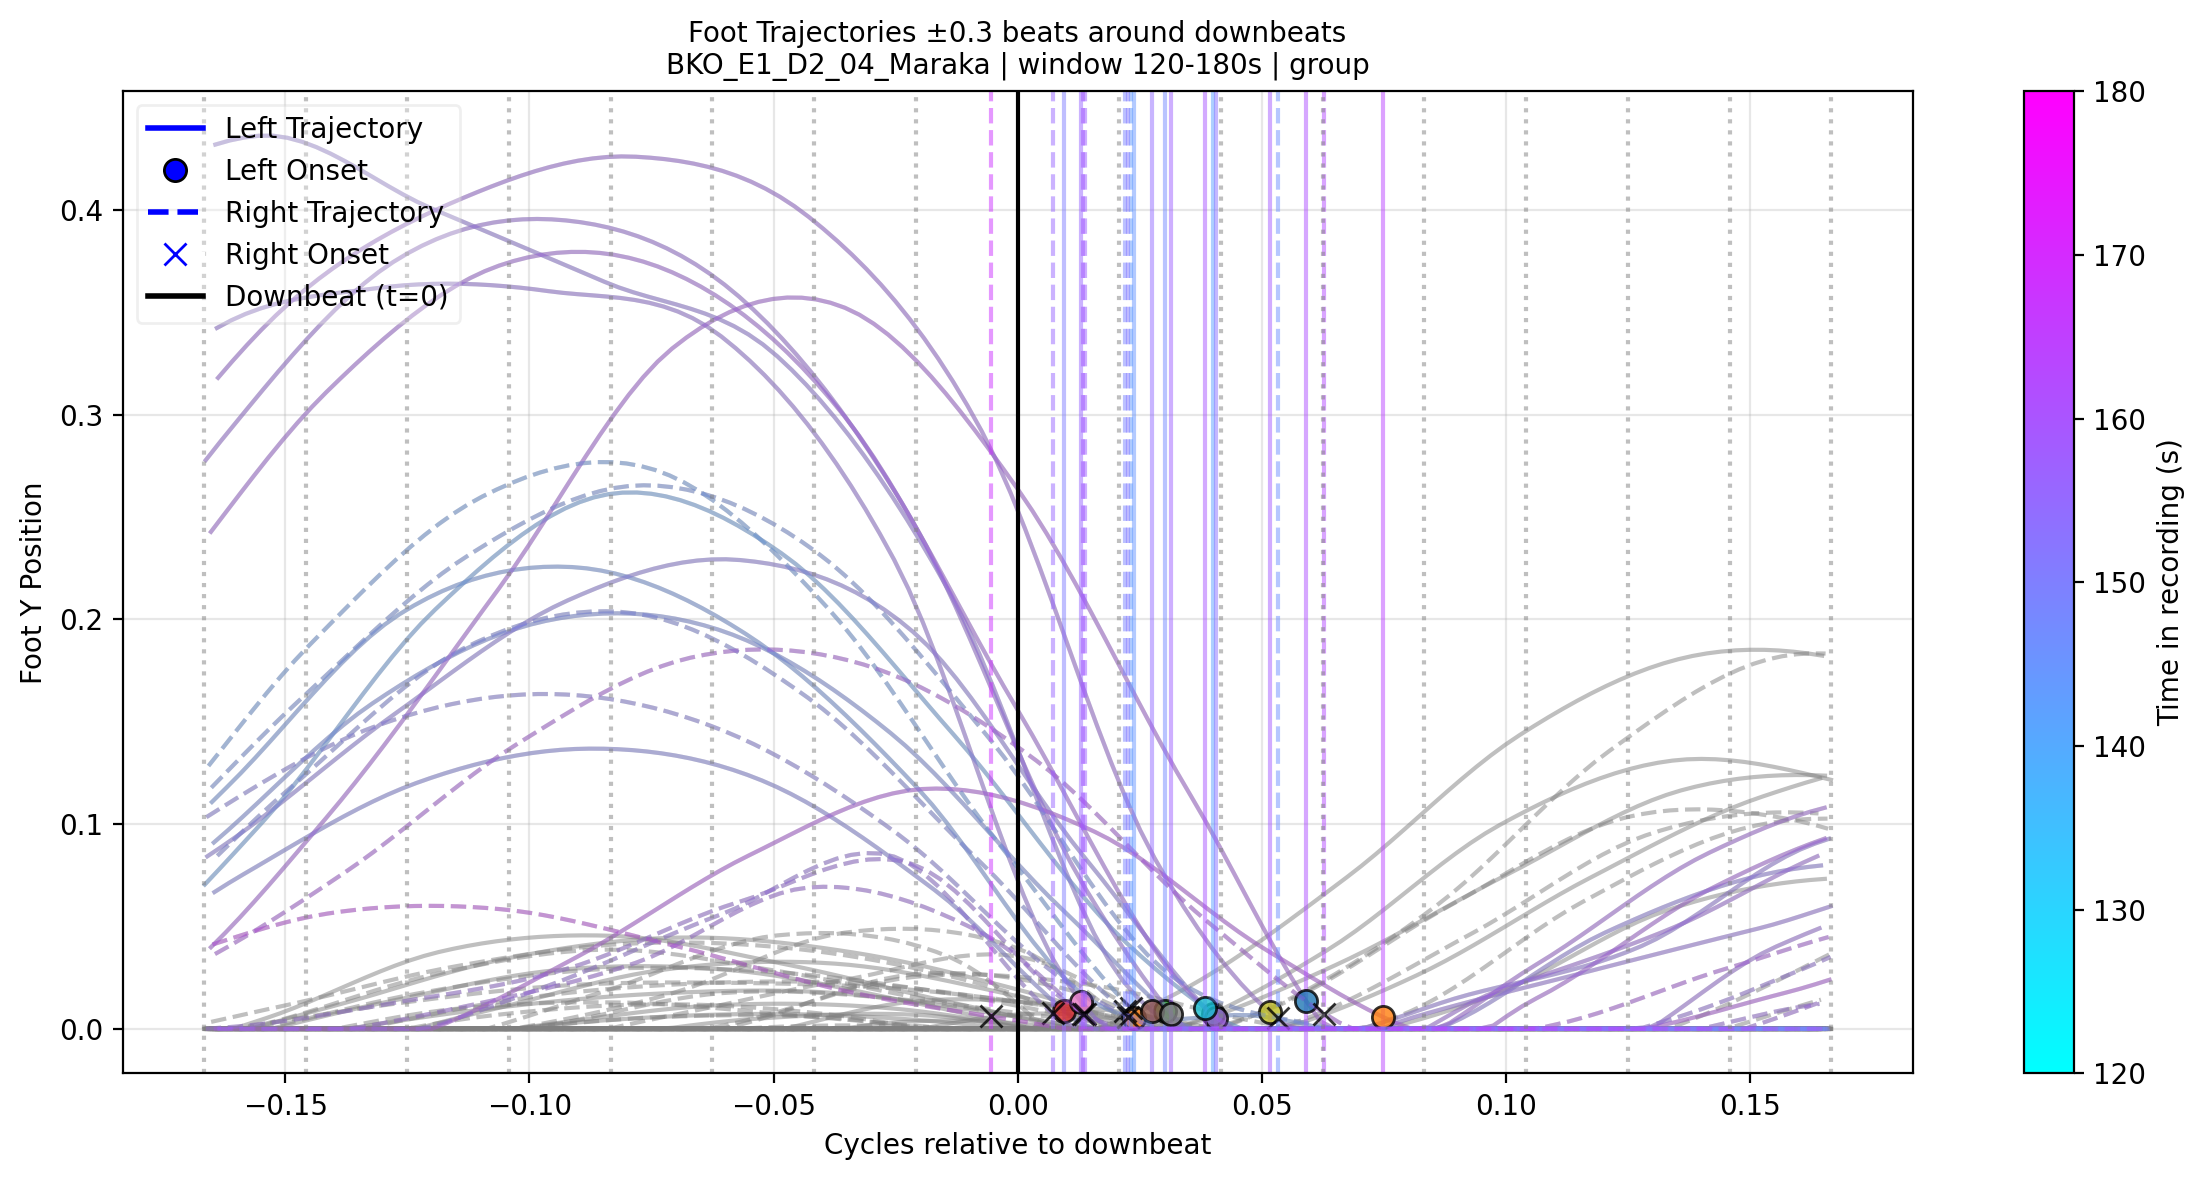

In [8]:
fig, ax = plot_foot_trajectories(
    file_name="BKO_E1_D2_04_Maraka",
    mode="group",
    base_path_cycles="data/virtual_cycles",
    base_path_logs="data/logs_v1_may",
    W_start= 120, W_end= 180,
    n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8,
    use_cycles=True,
    show_gray_plots=True
)
plt.show()

## V6: plot_foot_trajectories_by_beat

In [9]:
def plot_foot_trajectories_by_beat(
    file_name: str,
    mode: str,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    W_start: float = 170.0,
    W_end: float = 185.0,
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True
):
    """
    Plot left- and right-foot Y-position trajectories ±window around each beat (1,2,3,4),
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    """
    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # trim to window
    win_mask = (times >= W_start) & (times <= W_end)
    t_win = times[win_mask]
    L_win = Lz[win_mask]
    R_win = Rz[win_mask]

    # cycles (downbeats)
    cyc_df = pd.read_csv(cycles_csv)
    cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= W_start) & (cyc_df["Virtual Onset"] <= W_end)]
    onsets = cyc_df["Virtual Onset"].values[:-1]
    durations = np.diff(cyc_df["Virtual Onset"].values)
    avg_cycle = durations.mean()

    # foot onsets
    left_df  = pd.read_csv(left_onsets_csv)
    right_df = pd.read_csv(right_onsets_csv)
    left_times  = left_df[ (left_df["time_sec"]>=W_start)&(left_df["time_sec"]<=W_end) ]["time_sec"].values
    right_times = right_df[(right_df["time_sec"]>=W_start)&(right_df["time_sec"]<=W_end)]["time_sec"].values

    # window half-width in seconds
    beat_len   = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win   = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')
    t_range = W_end - W_start

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        beat_offset = beat_idx * beat_len  # Time offset for this beat
        
        # Plot gray trajectories if enabled
        if show_gray_plots:
            for c in onsets:
                beat_time = c + beat_offset  # Time of this beat in this cycle
                m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
                tr = t_win[m] - beat_time
                if use_cycles:
                    tr = tr / avg_cycle
                ax.plot(tr, L_win[m], '-', color='gray', alpha=0.1)
                ax.plot(tr, R_win[m], '--', color='gray', alpha=0.1)

        # Collect cycles that have foot onsets near this beat
        cyc_L, L_near = [], {}
        cyc_R, R_near = [], {}
        
        for c in onsets:
            beat_time = c + beat_offset
            # Left foot
            hits = left_times[(left_times>=beat_time-half_win)&(left_times<=beat_time+half_win)]
            if len(hits):
                cyc_L.append(c)
                L_near[c] = hits
            # Right foot
            hits = right_times[(right_times>=beat_time-half_win)&(right_times<=beat_time+half_win)]
            if len(hits):
                cyc_R.append(c)
                R_near[c] = hits

        # Plot left foot trajectories with onsets
        for i, c in enumerate(cyc_L):
            col = cmap((c-W_start)/t_range)
            beat_time = c + beat_offset
            m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
            tr = t_win[m] - beat_time
            if use_cycles:
                tr = tr / avg_cycle
            ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                    label="Left Foot" if i==0 else "")
            for lt in L_near[c]:
                rel = lt - beat_time
                if use_cycles:
                    rel = rel / avg_cycle
                ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', alpha=0.8)

        # Plot right foot trajectories with onsets
        for i, c in enumerate(cyc_R):
            col = cmap((c-W_start)/t_range)
            beat_time = c + beat_offset
            m = (t_win>=beat_time-half_win)&(t_win<=beat_time+half_win)
            tr = t_win[m] - beat_time
            if use_cycles:
                tr = tr / avg_cycle
            ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                    label="Right Foot" if i==0 else "")
            for rt in R_near[c]:
                rel = rt - beat_time
                if use_cycles:
                    rel = rel / avg_cycle
                ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='k', alpha=0.8)

        # Decorations for each subplot
        ax.axvline(0, color='k', linewidth=1.5, label="Beat (t=0)")
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / avg_cycle
                ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

        xlabel = "Cycles relative to beat" if use_cycles else "Time relative to beat (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        if beat_idx == 0:
            custom = [
                Line2D([0],[0],color='blue',linestyle='-', lw=2),
                Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
                Line2D([0],[0],color='blue',linestyle='--', lw=2),
                Line2D([0],[0],marker='x', color='w', markeredgecolor='blue', ms=8),
                Line2D([0],[0],color='k', lw=2)
            ]
            labels = ["Left Trajectory","Left Onset","Right Trajectory",
                     "Right Onset","Beat (t=0)"]
            ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(W_start, W_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around each beat\n"
        f"{file_name} | window {W_start}-{W_end}s | {mode}",
        fontsize=10
    )
    # plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # Make room for suptitle
    fig.set_constrained_layout(True)


    return fig, axes

### single plot

In [ ]:
fig, ax = plot_foot_trajectories_by_beat(
    file_name="BKO_E1_D2_04_Maraka",
    mode="group",
    base_path_cycles="data/virtual_cycles",
    base_path_logs="data/logs_v1_may",
    W_start= 120, W_end= 180,
    n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8,
    use_cycles=True,
    show_gray_plots=True
)
plt.show()

### batch plots

In [10]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract a (start, end) tuple or None
    def get_segment(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return (df["Start (in sec)"].iat[0],
                df["End (in sec)"].iat[0])

    # build a dict of segments
    segments = {
        "group":      get_segment(mode_group,      "gr"),
        "individual": get_segment(mode_individual, "in"),
        "audience":   get_segment(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, tup in tsegment.items():
        fig, ax = plot_foot_trajectories_by_beat(
            file_name= file_name,
            mode = mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            W_start=tup[0], W_end=tup[1],
            n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8,
            use_cycles=True,
            show_gray_plots=True
        )
        fig.savefig(os.path.join(save_dir, f"{file_name}_{tup[0]}_{tup[1]}.png"))
        plt.close(fig)

⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'au', skipping.
⚠️  No rows for mode 'gr', skipping.
⚠️  No rows for mode 'in', skipping.


## plot_foot_trajectories_by_subdiv

In [11]:
def plot_foot_trajectories_by_subdiv(
    file_name: str,
    mode: str,
    subdiv_set: list,  # e.g. [2,5,8,11] or [3,6,9,12]
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    frame_rate: float = 240,
    W_start: float = 170.0,
    W_end: float = 185.0,
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    figsize: tuple = (12, 6),
    dpi: int = 200,
    use_cycles: bool = True,
    show_gray_plots: bool = True
):
    """
    Plot left- and right-foot Y-position trajectories ±window around specified subdivisions,
    marking foot-onset times for cycles that have an onset in the window.
    Optionally plots trajectories for cycles without onsets in gray.

    Parameters
    ----------
    [previous parameters remain the same]
    subdiv_set : list
        List of subdivisions to align to (e.g. [2,5,8,11] for Set 2 or [3,6,9,12] for Set 3)
        Must have length equal to n_beats_per_cycle
    """
    if len(subdiv_set) != n_beats_per_cycle:
        raise ValueError(f"subdiv_set must have length {n_beats_per_cycle}")

    # build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv  = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv    = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv   = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")

    # load data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate

    # interpolation functions
    L_interp = interp1d(times, Lz, bounds_error=False, fill_value="extrapolate")
    R_interp = interp1d(times, Rz, bounds_error=False, fill_value="extrapolate")

    # trim to window
    win_mask = (times >= W_start) & (times <= W_end)
    t_win = times[win_mask]
    L_win = Lz[win_mask]
    R_win = Rz[win_mask]

    # cycles (downbeats)
    cyc_df = pd.read_csv(cycles_csv)
    cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= W_start) & (cyc_df["Virtual Onset"] <= W_end)]
    onsets = cyc_df["Virtual Onset"].values[:-1]
    durations = np.diff(cyc_df["Virtual Onset"].values)
    avg_cycle = durations.mean()

    # foot onsets
    left_df  = pd.read_csv(left_onsets_csv)
    right_df = pd.read_csv(right_onsets_csv)
    left_times  = left_df[ (left_df["time_sec"]>=W_start)&(left_df["time_sec"]<=W_end) ]["time_sec"].values
    right_times = right_df[(right_df["time_sec"]>=W_start)&(right_df["time_sec"]<=W_end)]["time_sec"].values

    # window half-width in seconds
    beat_len   = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win   = subdiv_len * nn

    # Create figure with subplots for each beat
    fig, axes = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
    axes = axes.flatten()
    cmap = plt.get_cmap('cool')
    t_range = W_end - W_start

    # For each beat position (1,2,3,4)
    for beat_idx, ax in enumerate(axes):
        # Calculate time offset for this subdivision
        subdiv_offset = (subdiv_set[beat_idx] - 1) * subdiv_len  # -1 because subdivisions are 1-based
        beat_offset = beat_idx * beat_len
        total_offset = beat_offset + subdiv_offset
        
        # Plot gray trajectories if enabled
        if show_gray_plots:
            for c in onsets:
                subdiv_time = c + total_offset
                m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
                tr = t_win[m] - subdiv_time
                if use_cycles:
                    tr = tr / avg_cycle
                ax.plot(tr, L_win[m], '-', color='gray', alpha=0.1)
                ax.plot(tr, R_win[m], '--', color='gray', alpha=0.1)

        # Collect cycles that have foot onsets near this subdivision
        cyc_L, L_near = [], {}
        cyc_R, R_near = [], {}
        
        for c in onsets:
            subdiv_time = c + total_offset
            # Left foot
            hits = left_times[(left_times>=subdiv_time-half_win)&(left_times<=subdiv_time+half_win)]
            if len(hits):
                cyc_L.append(c)
                L_near[c] = hits
            # Right foot
            hits = right_times[(right_times>=subdiv_time-half_win)&(right_times<=subdiv_time+half_win)]
            if len(hits):
                cyc_R.append(c)
                R_near[c] = hits

        # Plot left foot trajectories with onsets
        for i, c in enumerate(cyc_L):
            col = cmap((c-W_start)/t_range)
            subdiv_time = c + total_offset
            m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
            tr = t_win[m] - subdiv_time
            if use_cycles:
                tr = tr / avg_cycle
            ax.plot(tr, L_win[m], '-', color=col, alpha=0.3,
                    label="Left Foot" if i==0 else "")
            for lt in L_near[c]:
                rel = lt - subdiv_time
                if use_cycles:
                    rel = rel / avg_cycle
                ax.axvline(rel, color=col, linestyle='-', alpha=0.5)
                ax.plot(rel, L_interp(lt), 'o', ms=8, markeredgecolor='k', alpha=0.8)

        # Plot right foot trajectories with onsets
        for i, c in enumerate(cyc_R):
            col = cmap((c-W_start)/t_range)
            subdiv_time = c + total_offset
            m = (t_win>=subdiv_time-half_win)&(t_win<=subdiv_time+half_win)
            tr = t_win[m] - subdiv_time
            if use_cycles:
                tr = tr / avg_cycle
            ax.plot(tr, R_win[m], '--', color=col, alpha=0.3,
                    label="Right Foot" if i==0 else "")
            for rt in R_near[c]:
                rel = rt - subdiv_time
                if use_cycles:
                    rel = rel / avg_cycle
                ax.axvline(rel, color=col, linestyle='--', alpha=0.5)
                ax.plot(rel, R_interp(rt), 'x', ms=8, markeredgecolor='k', alpha=0.8)

        # Decorations for each subplot
        ax.axvline(0, color='k', linewidth=1.5, label="Subdivision (t=0)")
        for j in range(-nn, nn+1):
            if j!=0:
                pos = j*subdiv_len
                if use_cycles:
                    pos = pos / avg_cycle
                ax.axvline(pos, color='gray', linestyle=':', alpha=0.5)

        xlabel = "Cycles relative to subdivision" if use_cycles else "Time relative to subdivision (s)"
        ax.set_xlabel(xlabel)
        ax.set_ylabel("Foot Y Position")
        ax.set_title(f"Beat {beat_idx + 1}, Subdivision {subdiv_set[beat_idx]}")
        ax.grid(True, alpha=0.3)

        # Add legend only to first subplot
        if beat_idx == 0:
            custom = [
                Line2D([0],[0],color='blue',linestyle='-', lw=2),
                Line2D([0],[0],marker='o', color='w', markerfacecolor='blue', ms=8, markeredgecolor='k'),
                Line2D([0],[0],color='blue',linestyle='--', lw=2),
                Line2D([0],[0],marker='x', color='w', markeredgecolor='blue', ms=8),
                Line2D([0],[0],color='k', lw=2)
            ]
            labels = ["Left Trajectory","Left Onset","Right Trajectory",
                     "Right Onset","Subdivision (t=0)"]
            ax.legend(custom, labels, loc='upper left', framealpha=0.3)

    # Add colorbar to the figure
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(W_start, W_end))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=axes.ravel().tolist())
    cbar.set_label('Time in recording (s)')

    plt.suptitle(
        f"Foot Trajectories ±{2*nn/n_subdiv_per_beat/ n_beats_per_cycle:.1f} beats around subdivisions {subdiv_set}\n"
        f"{file_name} | window {W_start}-{W_end}s | {mode}",
        fontsize=10
    )
    
    plt.subplots_adjust(top=0.85)
    fig.set_constrained_layout(True)

    return fig, axes

### single plot

In [ ]:
fig, ax = plot_foot_trajectories_by_subdiv(
    file_name="BKO_E1_D2_04_Maraka",
    mode="group",
    base_path_cycles="data/virtual_cycles",
    base_path_logs="data/logs_v1_may",
    W_start= 120, W_end= 180,
    n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8,
    use_cycles=True,
    show_gray_plots=False,
    subdiv_set=[2,5,8,11]
)
plt.show()

### batch plots

In [ ]:
mode_csv_list = os.listdir("data/subset_dance_annotation")

for mode_csv in mode_csv_list:
    file_name = mode_csv.split("_Dancers")[0]
    mode_df = pd.read_csv("data/subset_dance_annotation/" + mode_csv)

    mode_group = mode_df[mode_df["mocap"] == "gr"].reset_index(drop=True)
    mode_individual = mode_df[mode_df["mocap"] == "in"].reset_index(drop=True)
    mode_audience = mode_df[mode_df["mocap"] == "au"].reset_index(drop=True)

    # helper to extract a (start, end) tuple or None
    def get_segment(df, name):
        if df.empty:
            print(f"⚠️  No rows for mode '{name}', skipping.")
            return None
        return (df["Start (in sec)"].iat[0],
                df["End (in sec)"].iat[0])

    # build a dict of segments
    segments = {
        "group":      get_segment(mode_group,      "gr"),
        "individual": get_segment(mode_individual, "in"),
        "audience":   get_segment(mode_audience,   "au")
    }

    # filter out the empty ones
    tsegment = {mode: seg for mode, seg in segments.items() if seg is not None}

    save_dir = f"output_static_plot/foot_trajectories/{file_name}"
    os.makedirs(save_dir, exist_ok=True)
    for mode, tup in tsegment.items():
        fig, ax = plot_foot_trajectories_by_subdiv(
            file_name= file_name,
            mode = mode,
            base_path_cycles="data/virtual_cycles",
            base_path_logs="data/logs_v1_may",
            W_start=tup[0], W_end=tup[1],
            n_beats_per_cycle=4, n_subdiv_per_beat=12, nn=8,
            use_cycles=True,
            show_gray_plots=True,
            subdiv_set=[2,5,8,11]
        )
        fig.savefig(os.path.join(save_dir, f"{file_name}_{tup[0]}_{tup[1]}.png"))
        plt.close(fig)

In [15]:
mode_individual

,Start,End,Length,Name,Notes,mocap,Start (in sec),End (in sec),Length (in sec),Part,part time
0,"00:02:09,340","00:02:41,160","00:00:31,820",tm,mocap,in,129.34,161.16,31.82,1,23.487
1,"00:03:34,640","00:04:09,540","00:00:34,900",tm,mocap,in,214.64,249.54,34.90,1,23.487
2,"00:03:37,060","00:04:09,740","00:00:32,680",nd,NaN,in,217.06,249.74,32.68,1,23.487


## extract_cycle_videos_and_plots WORKING

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import subprocess

def extract_cycle_videos_and_plots(
    file_name: str,
    W_start: float,
    W_end: float,
    base_path_cycles: str = "data/virtual_cycles",
    base_path_logs: str = "data/logs_v1_may",
    video_path: str = "data/videos/BKO_E1_D5_01_Maraka_pre_R_Mix.mp4",
    frame_rate: float = 240,  # Trajectory data frame rate
    n_beats_per_cycle: int = 4,
    n_subdiv_per_beat: int = 12,
    nn: int = 8,
    save_dir: str = "cycle_videos",
    figsize: tuple = (10, 3),
    dpi: int = 100
):
    """
    Extract video segments and create corresponding trajectory animations
    for cycles that have foot onsets around their downbeats.
    Each video/plot shows [-cycle, 0-cycle, +cycle] around the downbeat.
    """
    # Create save directories
    video_dir = os.path.join(save_dir, "videos")
    plot_dir = os.path.join(save_dir, "plots")
    os.makedirs(video_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    
    # Build file paths
    cycles_csv = os.path.join(base_path_cycles, f"{file_name}_C.csv")
    logs_onset_dir = os.path.join(base_path_logs, f"{file_name}_T", "onset_info")
    left_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_onsets.csv")
    right_onsets_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_onsets.csv")
    left_zpos_csv = os.path.join(logs_onset_dir, f"{file_name}_T_left_foot_zpos.csv")
    right_zpos_csv = os.path.join(logs_onset_dir, f"{file_name}_T_right_foot_zpos.csv")
    
    # Load data
    cyc_df = pd.read_csv(cycles_csv)
    cyc_df = cyc_df[(cyc_df["Virtual Onset"] >= W_start) & (cyc_df["Virtual Onset"] <= W_end)]
    onsets = cyc_df["Virtual Onset"].values[:-1]
    durations = np.diff(cyc_df["Virtual Onset"].values)
    avg_cycle = durations.mean()
    
    # Load foot data
    left_df = pd.read_csv(left_onsets_csv)
    right_df = pd.read_csv(right_onsets_csv)
    left_times = left_df[(left_df["time_sec"]>=W_start)&(left_df["time_sec"]<=W_end)]["time_sec"].values
    right_times = right_df[(right_df["time_sec"]>=W_start)&(right_df["time_sec"]<=W_end)]["time_sec"].values
    
    # Load trajectory data
    Lz = pd.read_csv(left_zpos_csv)["zpos"].values
    Rz = pd.read_csv(right_zpos_csv)["zpos"].values
    n_frames = len(Lz)
    times = np.arange(n_frames) / frame_rate  # Times at 240fps
    
    # Calculate window parameters
    beat_len = avg_cycle / n_beats_per_cycle
    subdiv_len = beat_len / n_subdiv_per_beat
    half_win = subdiv_len * nn
    
    # Find cycles with foot onsets
    cyc_L, L_near = [], {}
    for c in onsets:
        hits = left_times[(left_times>=c-half_win)&(left_times<=c+half_win)]
        if len(hits):
            cyc_L.append(c)
            L_near[c] = hits

    cyc_R, R_near = [], {}
    for c in onsets:
        hits = right_times[(right_times>=c-half_win)&(right_times<=c+half_win)]
        if len(hits):
            cyc_R.append(c)
            R_near[c] = hits
    
    # Combine unique cycles with onsets
    cycles_with_onsets = sorted(set(cyc_L + cyc_R))
    
    print(f"\nFound {len(cycles_with_onsets)} cycles with foot onsets")
    
    # Process each cycle
    for i, downbeat in enumerate(cycles_with_onsets):
        # Calculate segment times
        start_time = downbeat - avg_cycle  # One cycle before
        end_time = downbeat + avg_cycle    # One cycle after
        duration = end_time - start_time
        
        # Calculate frame numbers for video (50fps)
        video_start_frame = int(start_time * 50)
        video_end_frame = int(end_time * 50)
        video_n_frames = video_end_frame - video_start_frame
        
        # Calculate frame numbers for trajectory (240fps)
        traj_start_frame = int(start_time * frame_rate)  # Use 240fps for trajectory data
        traj_end_frame = int(end_time * frame_rate)
        traj_n_frames = traj_end_frame - traj_start_frame
        
        # Extract video segment with audio using ffmpeg
        video_output_path = os.path.join(video_dir, f"{file_name}_cycle_{i+1:03d}.mp4")
        ffmpeg_cmd = [
            'ffmpeg', '-y',
            '-i', video_path,
            '-ss', str(start_time),
            '-t', str(duration),
            '-c:v', 'libx264',
            '-c:a', 'aac',
            video_output_path
        ]
        subprocess.run(ffmpeg_cmd, capture_output=True)
        
        # Trim trajectory data using frame numbers at 240fps
        L_win = Lz[traj_start_frame:traj_end_frame]
        R_win = Rz[traj_start_frame:traj_end_frame]
        t_win = times[traj_start_frame:traj_end_frame]
        
        # Get foot onsets for this segment
        segment_left_onsets = left_times[(left_times >= start_time) & (left_times <= end_time)]
        segment_right_onsets = right_times[(right_times >= start_time) & (right_times <= end_time)]
        
        # Create figure and axis
        fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
        
        # Calculate beat times
        beat_times = np.array([downbeat + i * beat_len for i in range(n_beats_per_cycle)])
        
        # Plot downbeat line (color 1)
        ax.axvline(downbeat, color='black', linestyle='-', linewidth=1, alpha=0.7)  # Blue

        # Plot other beat lines (color 2)
        for beat_time in beat_times[1:]:  # Skip first beat (downbeat) as it's already plotted
            ax.axvline(beat_time, color='#ff7f0e', linestyle='--', linewidth=1.5, alpha=0.5)  # Orange
        
        # Plot trajectories
        ax.plot(t_win, L_win, '-', color='blue', alpha=0.5, label='Left Foot')
        ax.plot(t_win, R_win, '--', color='green', alpha=0.5, label='Right Foot')
        
        # Plot foot onset markers
        for onset in segment_left_onsets:
            ax.axvline(onset, color='blue', linestyle='-', alpha=0.3)
            # Find closest time index for onset
            idx = np.argmin(np.abs(t_win - onset))
            ax.plot(onset, L_win[idx], 'o', color='blue', ms=8, alpha=0.8)
        
        for onset in segment_right_onsets:
            ax.axvline(onset, color='green', linestyle='--', alpha=0.3)
            # Find closest time index for onset
            idx = np.argmin(np.abs(t_win - onset))
            ax.plot(onset, R_win[idx], 'x', color='green', ms=8, alpha=0.8)
        
        # Set y-axis limits
        y_min = min(L_win.min(), R_win.min())
        y_max = max(L_win.max(), R_win.max())
        y_range = y_max - y_min
        ax.set_ylim(y_min - 0.1*y_range, y_max + 0.1*y_range)
        
        # Create vertical playhead
        v_playhead, = ax.plot([start_time, start_time], 
                            [y_min - 0.1*y_range, y_max + 0.1*y_range],
                            'k-', lw=2, alpha=0.7)
        
        # Set up the plot
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Foot Position')
        ax.set_title(f'Cycle {i+1} | Downbeat: {downbeat:.2f}s')
        ax.grid(True, alpha=0.3)
        
        # Add legend
        custom = [
            Line2D([0],[0], color='blue', linestyle='-', lw=2),
            # Line2D([0],[0], marker='o', color='w', markerfacecolor='blue', ms=8),
            Line2D([0],[0], color='green', linestyle='--', lw=2),
            # Line2D([0],[0], marker='x', color='w', markeredgecolor='green', ms=8),
            Line2D([0],[0], color='k', lw=1,),
            Line2D([0],[0], color='orange', lw=1,),
        ]
        # labels = ["Left Foot", "Left Onset", "Right Foot", "Right Onset", "Downbeat", "Beat"]
        labels = ["Left Foot", "Right Foot", "Downbeat", "Beat"]
        
        ax.legend(custom, labels, loc='upper left', framealpha=0.3)
        
        def update(frame):
            v_playhead.set_xdata([frame, frame])
            ax.set_title(f'Cycle {i+1} | Downbeat: {downbeat:.2f}s | Time: {frame:.2f}s')
            return v_playhead,
        
        # Create animation frames at 50fps
        frames = np.linspace(start_time, end_time, video_n_frames)
        anim = animation.FuncAnimation(
            fig, update, frames=frames,
            interval=1000/50,  # 50fps
            blit=True
        )
        
        # Save animation
        plot_output_path = os.path.join(plot_dir, f"{file_name}_cycle_{i+1:03d}.mp4")
        writer = animation.FFMpegWriter(fps=50, bitrate=2000)  # 50fps to match video
        anim.save(plot_output_path, writer=writer)
        plt.close(fig)
        
        print(f"Processed cycle {i+1}/{len(cycles_with_onsets)}")
        print(f"  Video saved: {video_output_path}")
        print(f"  Plot saved: {plot_output_path}")
        print(f"  Video duration: {duration:.3f}s")
        print(f"  Plot duration: {len(frames)/50:.3f}s")
        print(f"  Video frames: {video_n_frames}")
        print(f"  Trajectory frames: {traj_n_frames}")
        print(f"  Frame times: {frames[0]:.3f} to {frames[-1]:.3f}")
    
    print("\nProcessing complete!")

if __name__ == "__main__":
    # Example usage
    file_name = "BKO_E1_D5_01_Maraka"
    W_start = 70.0
    W_end = 90.0
    video_path = "data/videos/BKO_E1_D5_01_Maraka_pre_R_Mix.mp4"
    
    extract_cycle_videos_and_plots(
        file_name, W_start, W_end,
        video_path=video_path
    )

## concatenate_and_overlay_videos

In [47]:
def create_concat_file(video_dir, output_file, prefix):
    """Create a text file listing all videos in order for concatenation"""
    with open(output_file, 'w') as f:
        # Get all video files and sort them
        video_files = sorted([f for f in os.listdir(video_dir) if f.startswith(prefix) and f.endswith('.mp4')])
        # Write each file path - use relative path from the text file location
        for video in video_files:
            # Get relative path from output_file to video_dir
            rel_path = os.path.relpath(os.path.join(video_dir, video), os.path.dirname(output_file))
            f.write(f"file '{rel_path}'\n")

In [52]:
def concatenate_and_overlay_videos(file_name, save_dir):
    """Concatenate cycle videos and plot videos, then overlay them"""
    video_dir = os.path.join(save_dir, "videos")
    plot_dir = os.path.join(save_dir, "plots")
    
    # Create text files for concatenation
    video_list = os.path.join(save_dir, "video_list.txt")
    plot_list = os.path.join(save_dir, "plot_list.txt")
    
    create_concat_file(video_dir, video_list, f"{file_name}_cycle_")
    create_concat_file(plot_dir, plot_list, f"{file_name}_cycle_")
    
    # Concatenate cycle videos
    concat_video = os.path.join(save_dir, "concatenated_video.mp4")
    try:
        result = subprocess.run([
            'ffmpeg', '-y',
            '-f', 'concat',
            '-safe', '0',
            '-i', video_list,
            '-c', 'copy',
            concat_video
        ], capture_output=True, text=True)
        if result.returncode != 0:
            print("Error concatenating videos:", result.stderr)
            return
    except Exception as e:
        print("Error running ffmpeg:", str(e))
        return
    
    # Concatenate plot videos
    concat_plot = os.path.join(save_dir, "concatenated_plot.mp4")
    try:
        result = subprocess.run([
            'ffmpeg', '-y',
            '-f', 'concat',
            '-safe', '0',
            '-i', plot_list,
            '-c', 'copy',
            concat_plot
        ], capture_output=True, text=True)
        if result.returncode != 0:
            print("Error concatenating plots:", result.stderr)
            return
    except Exception as e:
        print("Error running ffmpeg:", str(e))
        return
    
    # Overlay plot on video
    final_output = os.path.join(save_dir, f"{file_name}_final_output.mp4")
    try:
        result = subprocess.run([
            'ffmpeg', '-y',
            '-i', concat_video,
            '-i', concat_plot,
            '-filter_complex', "[0:v][1:v]overlay=(main_w-overlay_w)/2:main_h-overlay_h-10", #'[0:v][1:v]overlay=main_w-overlay_w-10:10',
            '-c:a', 'copy',
            final_output
        ], capture_output=True, text=True)
        if result.returncode != 0:
            print("Error overlaying videos:", result.stderr)
            return
    except Exception as e:
        print("Error running ffmpeg:", str(e))
        return
    
    # Clean up temporary files
    for file in [video_list, plot_list, concat_video, concat_plot]:
        if os.path.exists(file):
            os.remove(file)
    
    print(f"\nFinal output saved: {final_output}")

In [ ]:
# At the end of extract_cycle_videos_and_plots, after processing all cycles:
save_dir = "cycle_videos"
file_name = "BKO_E1_D5_01_Maraka"
concatenate_and_overlay_videos(file_name, save_dir)